<a href="https://colab.research.google.com/github/CopitoFrostbite/ss_innova/blob/main/Cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Librerias
!pip install scikit_posthocs
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import scikit_posthocs as sp
import xgboost as xgb

from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV


In [8]:
#Maps
#Mapa para la columna Race
race_mapping = {
    'White': 0,
    'Hispanic': 1,
    'Black': 2,
    'Asian': 3,
    'American Indian/Alaskan Native': 4,
    'Other': 5
}
#Mapa para la columna Sex
gender_mapping = {
    'Male': 0,
    'Female': 1
}
#Mapa para la columna AgeCategory
age_mapping = {
    '18-24': 21,
    '25-29': 27,
    '30-34': 32,
    '35-39': 37,
    '40-44': 42,
    '45-49': 47,
    '50-54': 52,
    '55-59': 57,
    '60-64': 62,
    '65-69': 67,
    '70-74': 72,
    '75-79': 77,
    '80 or older': 85
}

#Mapa para la columna Diabetic
diabetic_mapping = {
    'No': 0,
    'Yes': 1,
    'No, borderline diabetes': 2,
    'Yes (during pregnancy)': 3
}

#Mapa para la columna GenHealth
gen_health_mapping = {
    'Excellent': 5,
    'Very good': 4,
    'Good': 3,
    'Fair': 2,
    'Poor': 1
}





In [9]:
#Variables

#Dataset
cardio = pd.read_csv('/content/train.csv')
boolean_columns = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic','PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease']

#Labels
race_labels = {0: 'White', 1: 'Hispanic', 2: 'Black', 3: 'Asian', 4:'American Native', 5: 'Other'}

# Resultados de las pruebas de Chi-cuadrado
chi2_results = {}

In [10]:
#Funciones

#transformar horas a minutos
def convert_to_minutes(sleep_time):
    if 'hrs' in sleep_time:
        hours = int(sleep_time.split()[0])
        return hours * 60
    elif 'min' in sleep_time:
        return int(sleep_time.split()[0])
    else:
        return None

In [11]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [12]:
cardio.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11030 entries, 0 to 11029
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        11030 non-null  object 
 1   BMI               11030 non-null  float64
 2   Smoking           11030 non-null  object 
 3   AlcoholDrinking   11030 non-null  object 
 4   Stroke            11030 non-null  object 
 5   PhysicalHealth    11030 non-null  float64
 6   MentalHealth      11030 non-null  float64
 7   DiffWalking       11030 non-null  object 
 8   Sex               11030 non-null  object 
 9   AgeCategory       11030 non-null  object 
 10  Race              11029 non-null  object 
 11  Diabetic          11029 non-null  object 
 12  PhysicalActivity  11029 non-null  object 
 13  GenHealth         11029 non-null  object 
 14  SleepTime         11029 non-null  object 
 15  Asthma            11029 non-null  object 
 16  KidneyDisease     11029 non-null  object

In [13]:
cardio.head()

,Patient_ID,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease
0,Patient_118020,45.61,Yes,No,No,0.0,0.0,No,Male,35-39,White,No,Yes,Good,360 min,No,No,No,No
1,Patient_196414,37.59,Yes,No,No,7.0,20.0,No,Female,30-34,Hispanic,No,Yes,Very good,480 min,No,No,No,No
2,Patient_107743,19.37,Yes,No,No,0.0,0.0,No,Female,50-54,White,No,Yes,Good,2 hrs,No,No,No,No
3,Patient_28303,48.42,No,No,No,30.0,15.0,No,Female,30-34,White,No,Yes,Fair,8 hrs,No,No,No,No
4,Patient_118489,27.12,No,No,No,0.0,5.0,No,Male,65-69,White,No,Yes,Very good,360 min,Yes,No,No,No


In [14]:
cardio.describe()

,BMI,PhysicalHealth,MentalHealth
count,11030.000000,11030.000000,11030.000000
mean,28.338242,3.261378,3.923028
std,6.444785,7.820995,7.996643
min,12.840000,0.000000,0.000000
25%,24.012500,0.000000,0.000000
50%,27.320000,0.000000,0.000000
75%,31.387500,2.000000,3.000000
max,82.390000,30.000000,30.000000


In [15]:
cardio.describe(include=[bool, 'category', 'object'])

,Patient_ID,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease
count,11030,11030,11030,11030,11030,11030,11030,11029,11029,11029,11029,11029,11029,11029,11029,11029
unique,11030,2,2,2,2,2,13,6,4,2,5,38,2,2,2,2
top,Patient_118020,No,No,No,No,Female,60-64,White,No,Yes,Very good,8 hrs,No,No,No,No
freq,1,6487,10301,10604,9514,5817,1157,8464,9291,8504,3939,2312,9602,10642,10056,10054


In [16]:
cardio["HeartDisease"].value_counts()

HeartDisease
No     10054
Yes      975
Name: count, dtype: int64

In [17]:
sample_incomplete_rows = cardio[cardio.isnull().any(axis=1)].head()
sample_incomplete_rows

,Patient_ID,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease
11029,Patient_156220,23.49,No,No,No,0.0,0.0,Yes,Male,80 or older,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#Data Cleaning

#Delete inclomplete row
cardio = cardio[cardio['Patient_ID'] != 'Patient_156220']

#String to Boolean
columns_string_to_bool = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease']
cardio[columns_string_to_bool] = cardio[columns_string_to_bool].replace({'Yes': True, 'No': False})

#Using maps
cardio['Sex'] = cardio['Sex'].map(gender_mapping)
cardio['AgeCategory'] = cardio['AgeCategory'].map(age_mapping)
cardio['AgeCategory'] = cardio['AgeCategory'].astype(int)
cardio['Race'] = cardio['Race'].map(race_mapping)
cardio['Race'] = cardio['Race'].astype(int)
cardio['Diabetic'] = cardio['Diabetic'].map(diabetic_mapping)
cardio['GenHealth'] = cardio['GenHealth'].map(gen_health_mapping)

#Convert sleep time to minutes
cardio['SleepTime'] = cardio['SleepTime'].astype(str)
cardio['SleepTime'] = cardio['SleepTime'].apply(convert_to_minutes)

#Using Regex
cardio['Patient_ID'] = cardio['Patient_ID'].str.extract(r'(\d+)', expand=False).astype(int)

In [19]:
cardio.head()

,Patient_ID,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease
0,118020,45.61,True,False,False,0.0,0.0,False,0,37,0,0,True,3,360,False,False,False,False
1,196414,37.59,True,False,False,7.0,20.0,False,1,32,1,0,True,4,480,False,False,False,False
2,107743,19.37,True,False,False,0.0,0.0,False,1,52,0,0,True,3,120,False,False,False,False
3,28303,48.42,False,False,False,30.0,15.0,False,1,32,0,0,True,2,480,False,False,False,False
4,118489,27.12,False,False,False,0.0,5.0,False,0,67,0,0,True,4,360,True,False,False,False


In [20]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11029 entries, 0 to 11028
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        11029 non-null  int64  
 1   BMI               11029 non-null  float64
 2   Smoking           11029 non-null  bool   
 3   AlcoholDrinking   11029 non-null  bool   
 4   Stroke            11029 non-null  bool   
 5   PhysicalHealth    11029 non-null  float64
 6   MentalHealth      11029 non-null  float64
 7   DiffWalking       11029 non-null  bool   
 8   Sex               11029 non-null  int64  
 9   AgeCategory       11029 non-null  int64  
 10  Race              11029 non-null  int64  
 11  Diabetic          11029 non-null  int64  
 12  PhysicalActivity  11029 non-null  bool   
 13  GenHealth         11029 non-null  int64  
 14  SleepTime         11029 non-null  int64  
 15  Asthma            11029 non-null  bool   
 16  KidneyDisease     11029 non-null  bool   
 17

In [21]:
cardio.describe()

,Patient_ID,BMI,PhysicalHealth,MentalHealth,Sex,AgeCategory,Race,Diabetic,GenHealth,SleepTime
count,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000
mean,159968.307462,28.338682,3.261674,3.923384,0.527428,54.483725,0.543658,0.196845,3.599510,426.044066
std,92044.648807,6.444912,7.821288,7.996918,0.499270,18.342098,1.199845,0.502411,1.035988,87.237405
min,17.000000,12.840000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,1.000000,60.000000
25%,81554.000000,24.020000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,3.000000,360.000000
50%,159820.000000,27.320000,0.000000,0.000000,1.000000,57.000000,0.000000,0.000000,4.000000,420.000000
75%,240600.000000,31.390000,2.000000,3.000000,1.000000,67.000000,0.000000,0.000000,4.000000,480.000000
max,319777.000000,82.390000,30.000000,30.000000,1.000000,85.000000,5.000000,3.000000,5.000000,1320.000000


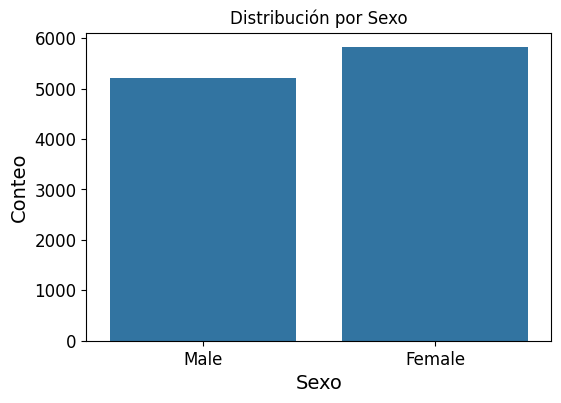

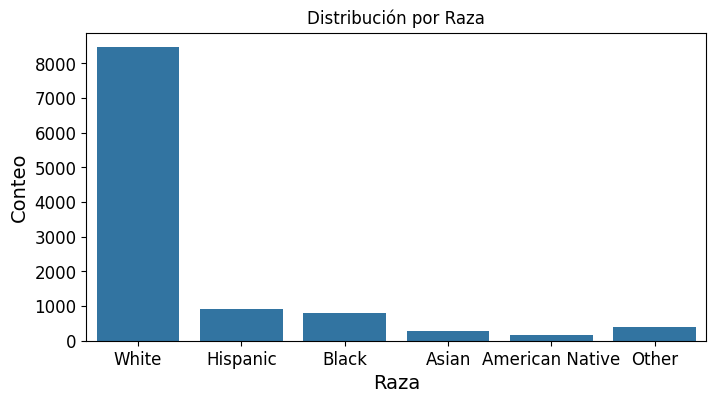

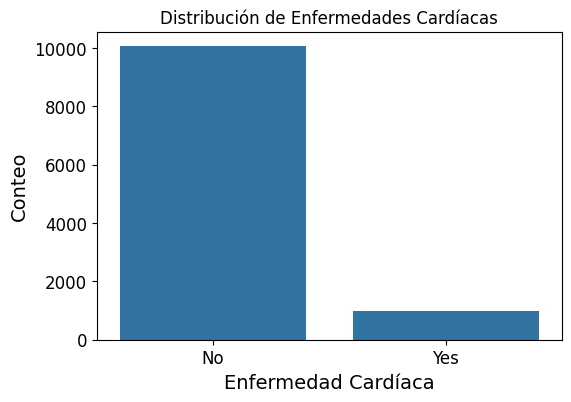

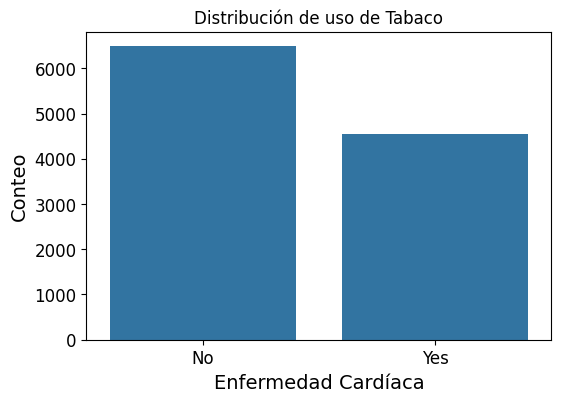

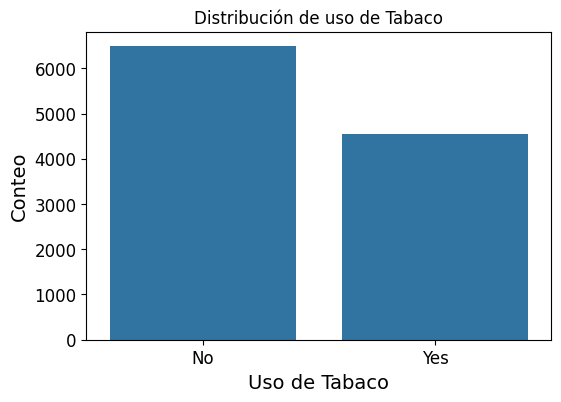

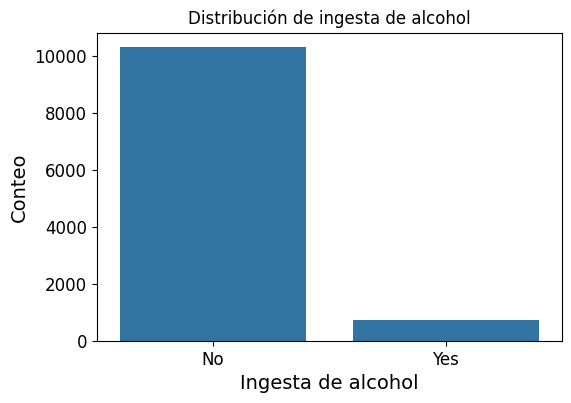

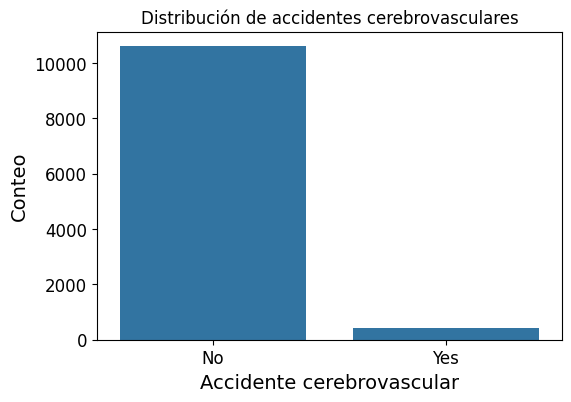

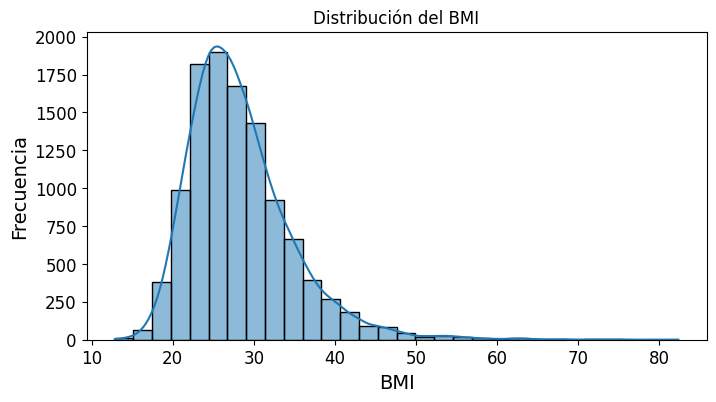

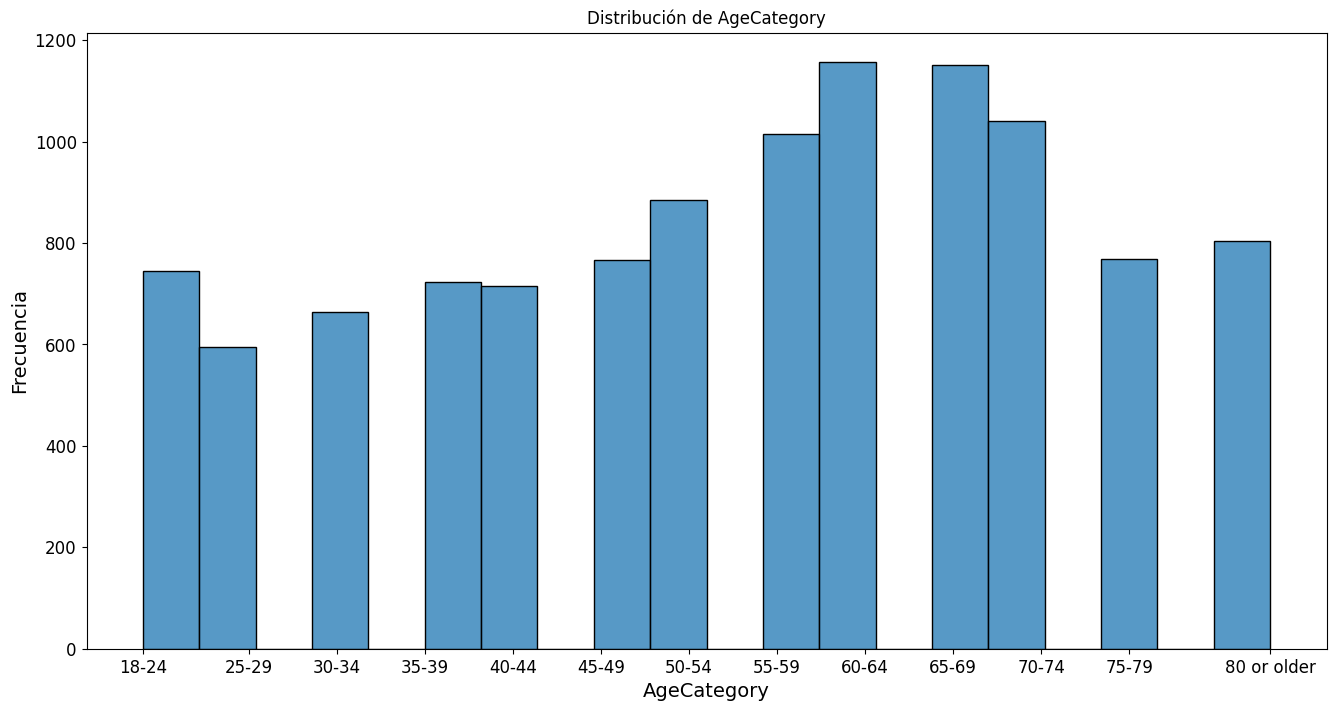

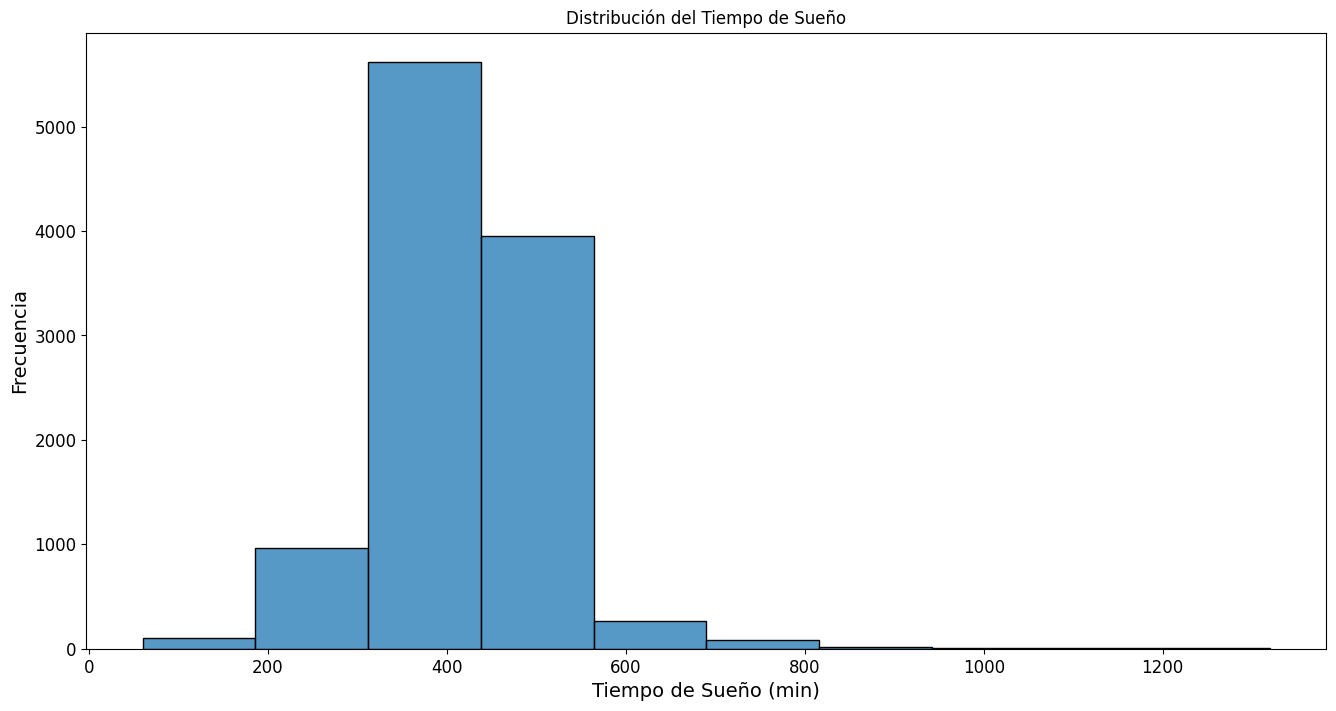

In [22]:
# Información general del dataset

# Distribución de Sex
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=cardio)
plt.title('Distribución por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

# Distribución de Race
plt.figure(figsize=(8, 4))
sns.countplot(x='Race', data=cardio)
plt.title('Distribución por Raza')
plt.xlabel('Raza')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1, 2, 3, 4,5], labels=['White', 'Hispanic', 'Black', 'Asian','American Native', 'Other'])
plt.show()

# Distribución de HeartDisease
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=cardio)
plt.title('Distribución de Enfermedades Cardíacas')
plt.xlabel('Enfermedad Cardíaca')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Distribución de Smoking
plt.figure(figsize=(6, 4))
sns.countplot(x='Smoking', data=cardio)
plt.title('Distribución de uso de Tabaco')
plt.xlabel('Enfermedad Cardíaca')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Distribución de Smoking
plt.figure(figsize=(6, 4))
sns.countplot(x='Smoking', data=cardio)
plt.title('Distribución de uso de Tabaco')
plt.xlabel('Uso de Tabaco')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Distribución de AlcoholDrinking
plt.figure(figsize=(6, 4))
sns.countplot(x='AlcoholDrinking', data=cardio)
plt.title('Distribución de ingesta de alcohol')
plt.xlabel('Ingesta de alcohol')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Distribución de Stroke
plt.figure(figsize=(6, 4))
sns.countplot(x='Stroke', data=cardio)
plt.title('Distribución de accidentes cerebrovasculares')
plt.xlabel('Accidente cerebrovascular')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Distribución de BMI
plt.figure(figsize=(8, 4))
sns.histplot(cardio['BMI'], bins=30, kde=True)
plt.title('Distribución del BMI')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de AgeCategory
plt.figure(figsize=(16, 8))
sns.histplot(cardio['AgeCategory'], bins=20)
plt.title('Distribución de AgeCategory')
plt.xlabel('AgeCategory')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[21, 27, 32, 37, 42,47,52,57,62,67,72,77,85], labels=['18-24','25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74','75-79', '80 or older'])

plt.show()

# Distribución de SleepTime
plt.figure(figsize=(16, 8))
sns.histplot(cardio['SleepTime'], bins=10)
plt.title('Distribución del Tiempo de Sueño')
plt.xlabel('Tiempo de Sueño (min)')
plt.ylabel('Frecuencia')

plt.show()

In [23]:
corr_matrix = cardio.corr()


corr_matrix["Race"].sort_values(ascending=False)

Race                1.000000
Diabetic            0.056818
MentalHealth        0.042238
BMI                 0.029874
Asthma              0.027740
KidneyDisease       0.019962
DiffWalking         0.017422
PhysicalHealth      0.014890
Stroke             -0.001019
Sex                -0.006881
HeartDisease       -0.007471
Smoking            -0.021625
Patient_ID         -0.027692
AlcoholDrinking    -0.029603
PhysicalActivity   -0.033323
SleepTime          -0.055410
GenHealth          -0.060670
SkinCancer         -0.108175
AgeCategory        -0.143862
Name: Race, dtype: float64

In [24]:
cardio["SleepTime"].value_counts()

SleepTime
480     3426
420     3358
360     2260
300      677
540      530
240      287
600      256
720       79
180       63
120       27
60        15
840       12
660        9
960        8
900        7
1200       5
780        4
1080       3
1320       2
1260       1
Name: count, dtype: int64

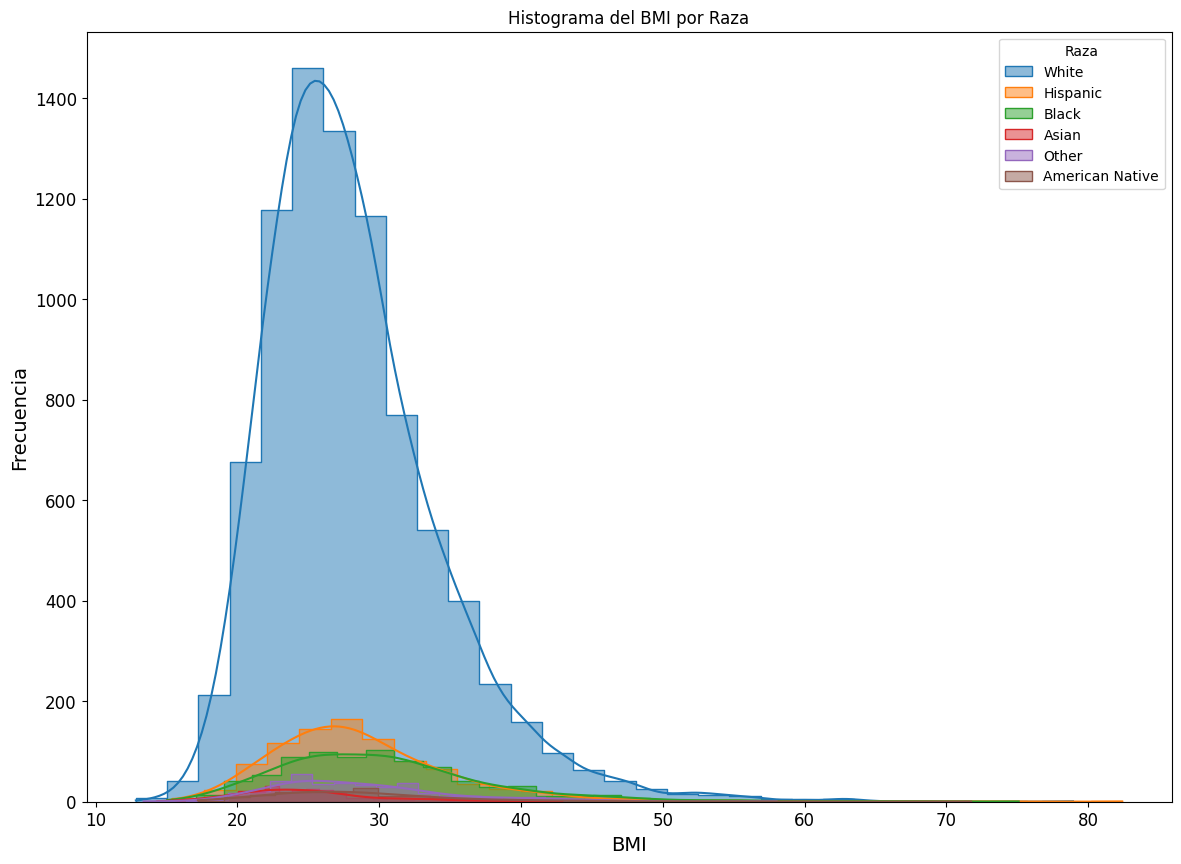

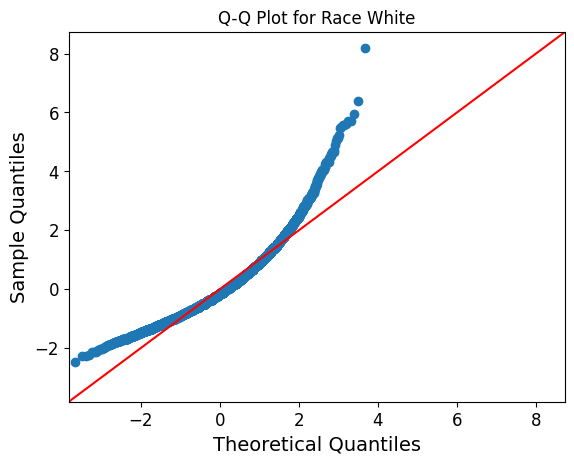

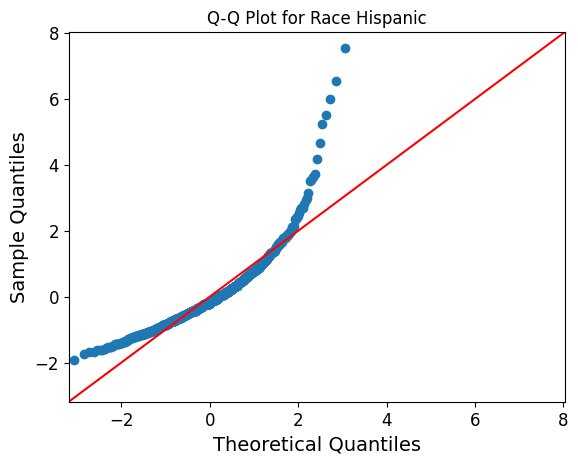

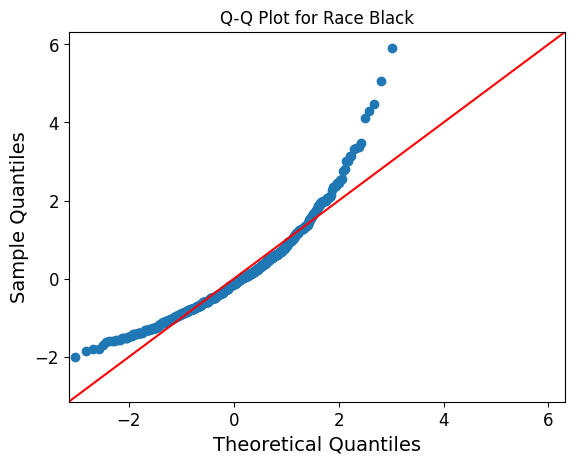

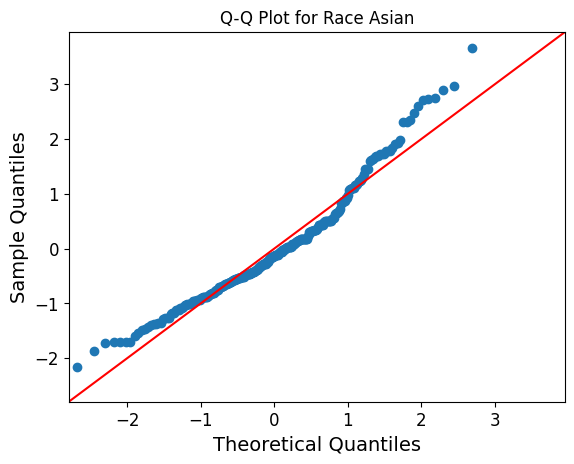

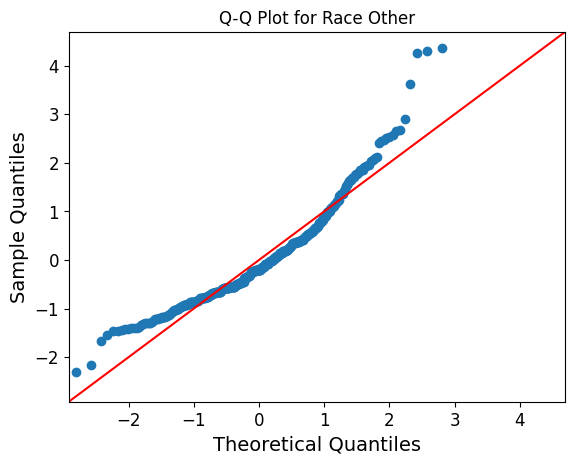

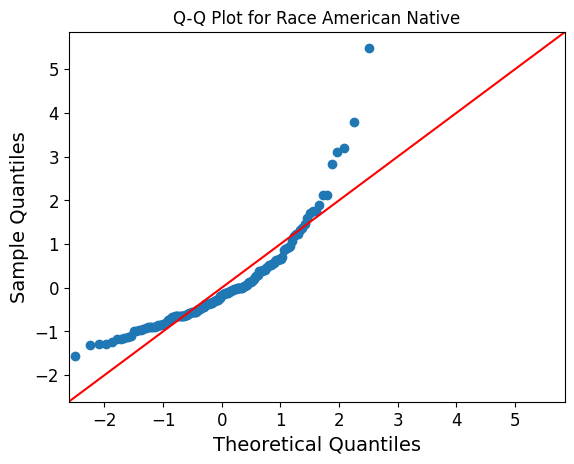

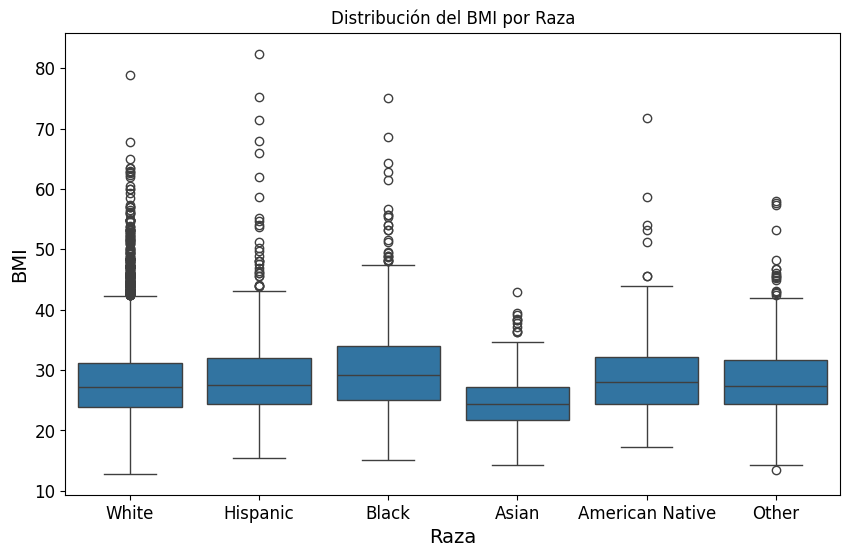

In [25]:
# Crear histogramas para la distribución del BMI por raza
plt.figure(figsize=(14, 10))


for race in cardio['Race'].unique():
    sns.histplot(cardio[cardio['Race'] == race]['BMI'], kde=True, label=race_labels[race], bins=30, element="step")

plt.title('Histograma del BMI por Raza')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.legend(title='Raza')
plt.show()

# Crear Q-Q Plots para visualizar la normalidad de los datos de BMI por raza
for race in cardio['Race'].unique():
    sm.qqplot((cardio[cardio['Race'] == race]['BMI'] - cardio[cardio['Race'] == race]['BMI'].mean()) / cardio[cardio['Race'] == race]['BMI'].std(), line ='45')
    plt.title(f'Q-Q Plot for Race {race_labels[race]}')
    plt.show()

# Boxplot del BMI por raza
plt.figure(figsize=(10, 6))
sns.boxplot(x='Race', y='BMI', data=cardio)
plt.title('Distribución del BMI por Raza')
plt.xlabel('Raza')
plt.ylabel('BMI')
plt.xticks(ticks=[0, 1, 2, 3, 4,5], labels=['White', 'Hispanic', 'Black', 'Asian','American Native' ,'Other'])
plt.show()




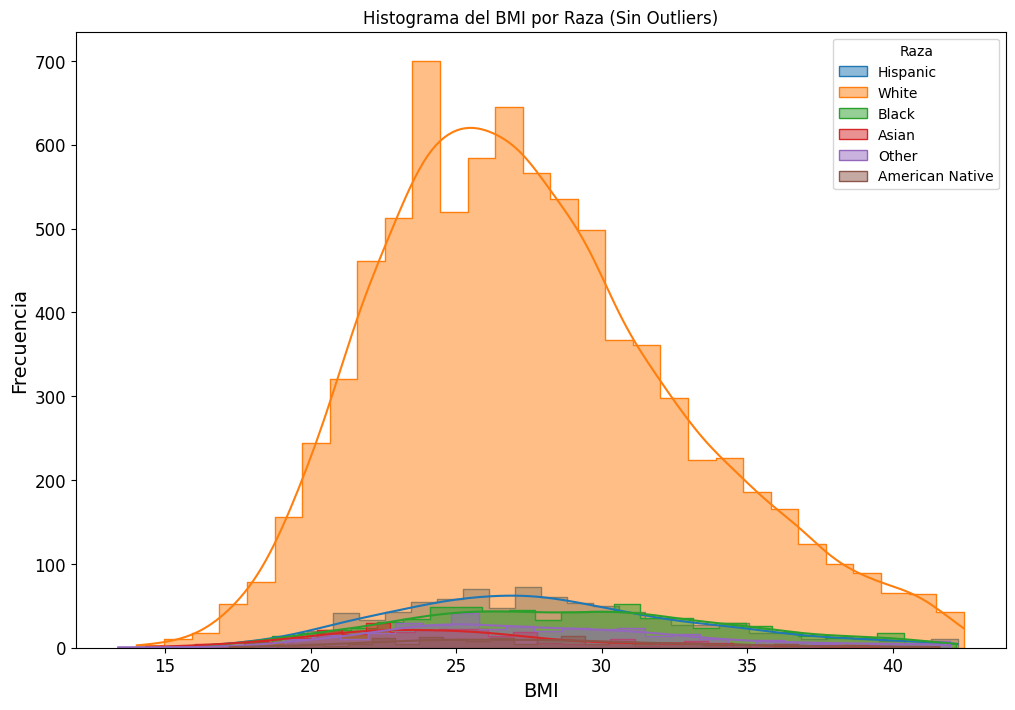

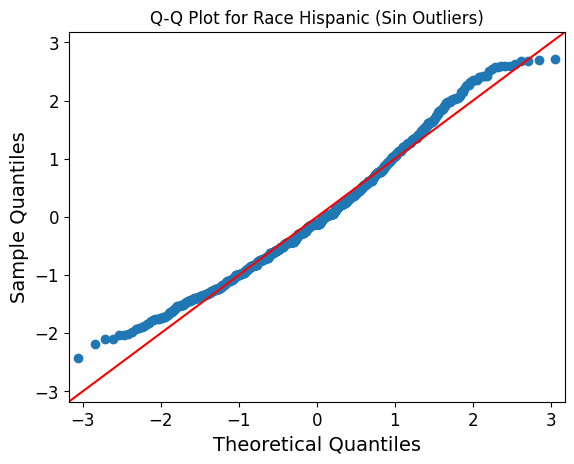

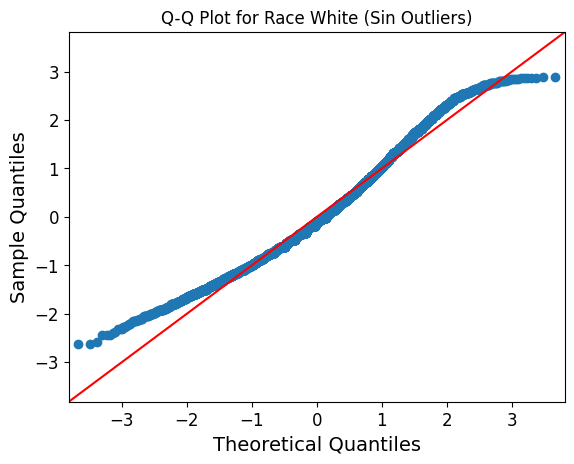

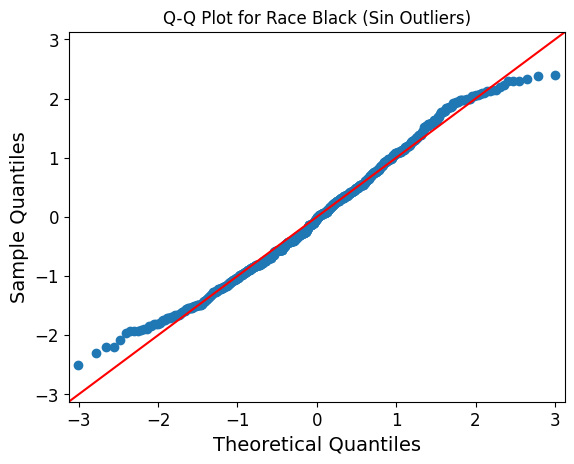

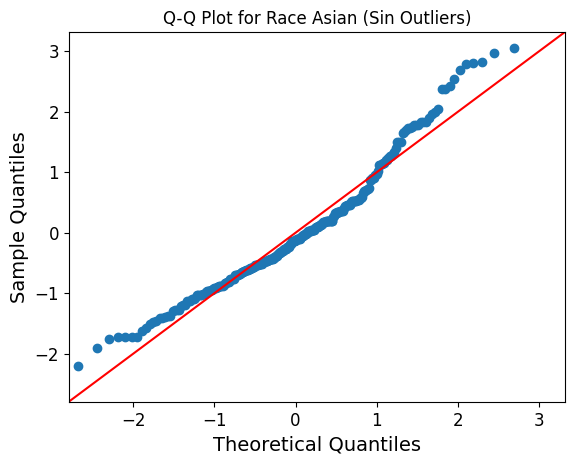

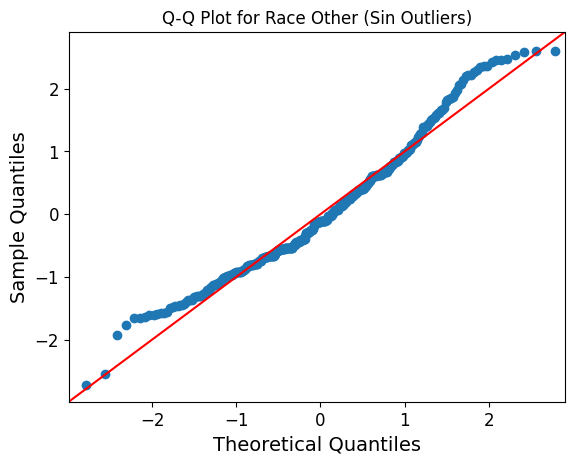

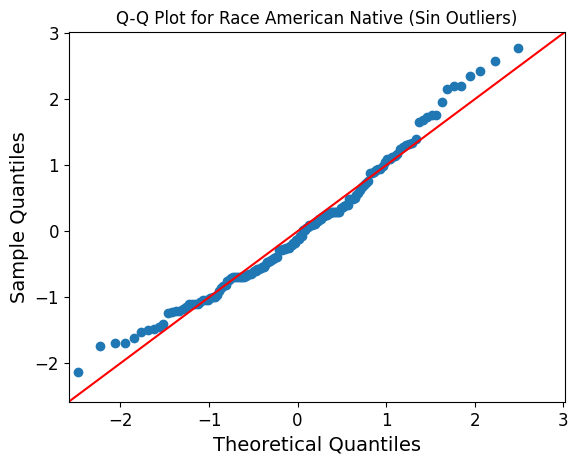

Resultado de la prueba de Kruskal-Wallis:
KruskalResult(statistic=135.72801762555275, pvalue=1.4468445847877284e-27)


In [26]:
# Calcular el rango intercuartílico (IQR) para el BMI
Q1 = cardio['BMI'].quantile(0.25)
Q3 = cardio['BMI'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
cardio_no_outliers = cardio[(cardio['BMI'] >= lower_bound) & (cardio['BMI'] <= upper_bound)]

# Crear histogramas para la distribución del BMI por raza sin outliers
plt.figure(figsize=(12, 8))
for race in cardio_no_outliers['Race'].unique():
    sns.histplot(cardio_no_outliers[cardio_no_outliers['Race'] == race]['BMI'], kde=True, label=race_labels[race], bins=30, element="step")

plt.title('Histograma del BMI por Raza (Sin Outliers)')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.legend(title='Raza')
plt.show()

# Crear Q-Q Plots para visualizar la normalidad de los datos de BMI por raza sin outliers
for race in cardio_no_outliers['Race'].unique():
    sm.qqplot((cardio_no_outliers[cardio_no_outliers['Race'] == race]['BMI'] - cardio_no_outliers[cardio_no_outliers['Race'] == race]['BMI'].mean()) / cardio_no_outliers[cardio_no_outliers['Race'] == race]['BMI'].std(), line ='45')
    plt.title(f'Q-Q Plot for Race {race_labels[race]} (Sin Outliers)')
    plt.show()

# Realizar la prueba de Kruskal-Wallis para BMI por raza
grouped_data = [cardio_no_outliers[cardio_no_outliers['Race'] == race]['BMI'] for race in cardio_no_outliers['Race'].unique()]
kruskal_result = kruskal(*grouped_data)

# Mostrar el resultado de la prueba
print("Resultado de la prueba de Kruskal-Wallis:")
print(kruskal_result)




In [27]:
# Realizar la prueba de Dunn para BMI por raza
dunn_result = sp.posthoc_dunn(cardio_no_outliers, val_col='BMI', group_col='Race', p_adjust='bonferroni')

# Mostrar los resultados de la prueba de Dunn
print(dunn_result)

              0             1             2             3             4  \
0  1.000000e+00  5.737391e-02  3.948882e-10  4.876588e-17  1.000000e+00   
1  5.737391e-02  1.000000e+00  3.224333e-02  4.870113e-19  1.000000e+00   
2  3.948882e-10  3.224333e-02  1.000000e+00  8.032096e-28  3.548345e-01   
3  4.876588e-17  4.870113e-19  8.032096e-28  1.000000e+00  9.106509e-08   
4  1.000000e+00  1.000000e+00  3.548345e-01  9.106509e-08  1.000000e+00   
5  1.000000e+00  1.000000e+00  5.821800e-02  3.335331e-13  1.000000e+00   

              5  
0  1.000000e+00  
1  1.000000e+00  
2  5.821800e-02  
3  3.335331e-13  
4  1.000000e+00  
5  1.000000e+00  


Interpretación de los p-values:

    p-value < 0.05: Existe una diferencia significativa entre los dos grupos raciales comparados.
    p-value >= 0.05: No existe una diferencia significativa entre los dos grupos raciales comparados.

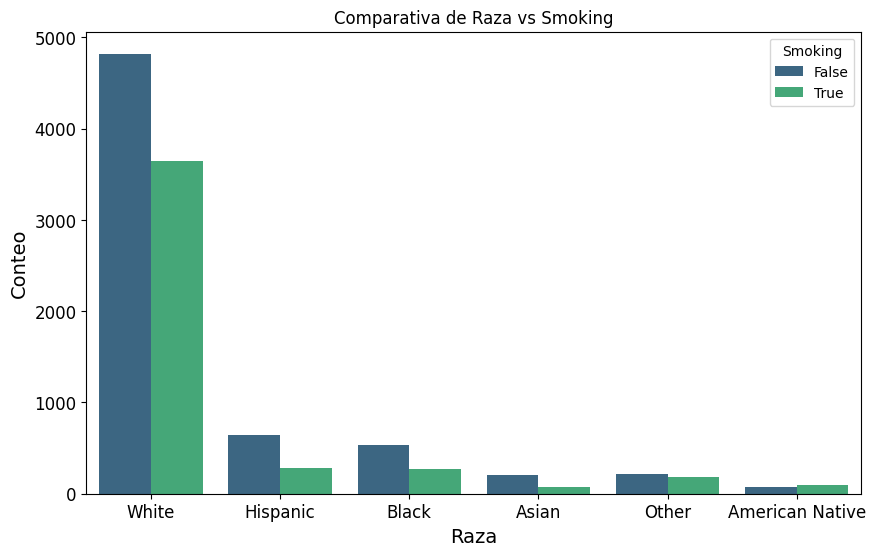

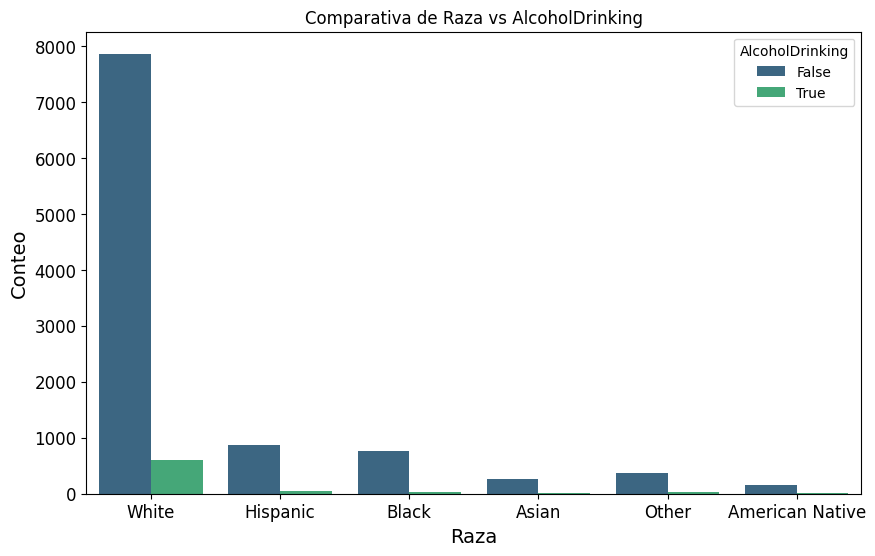

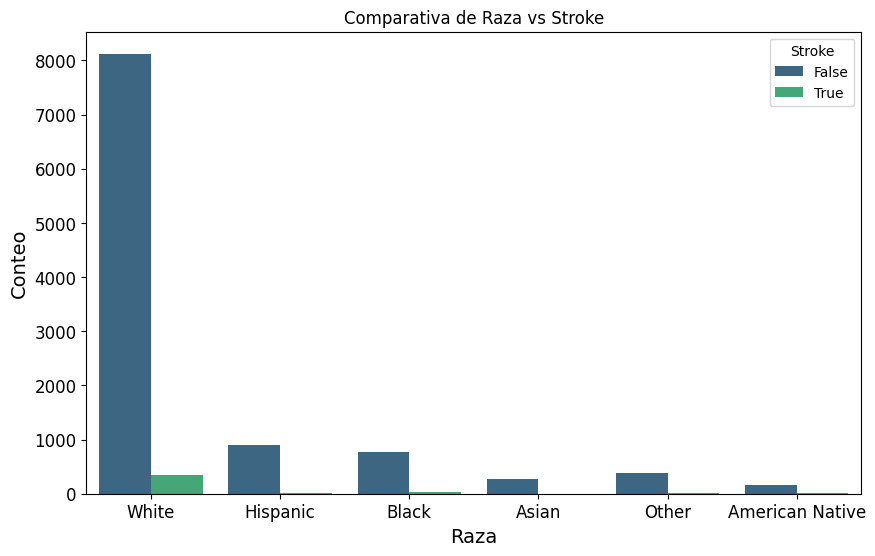

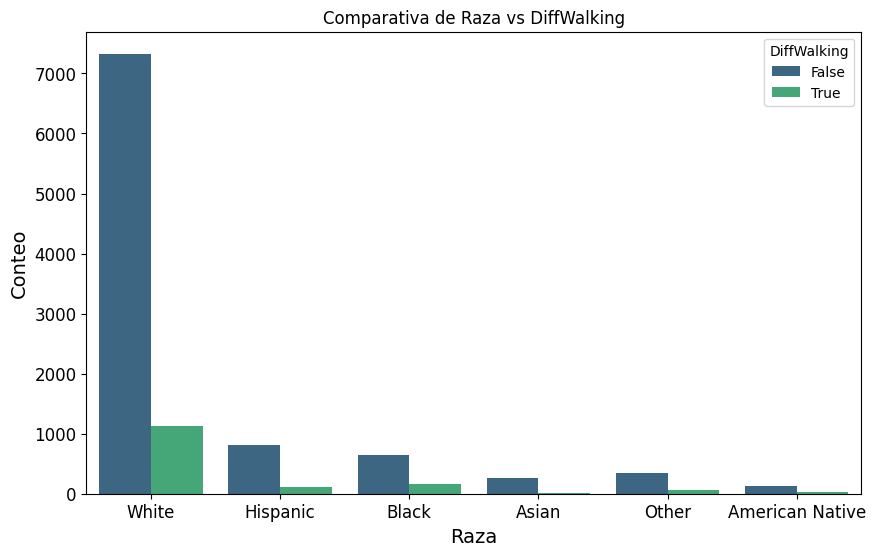

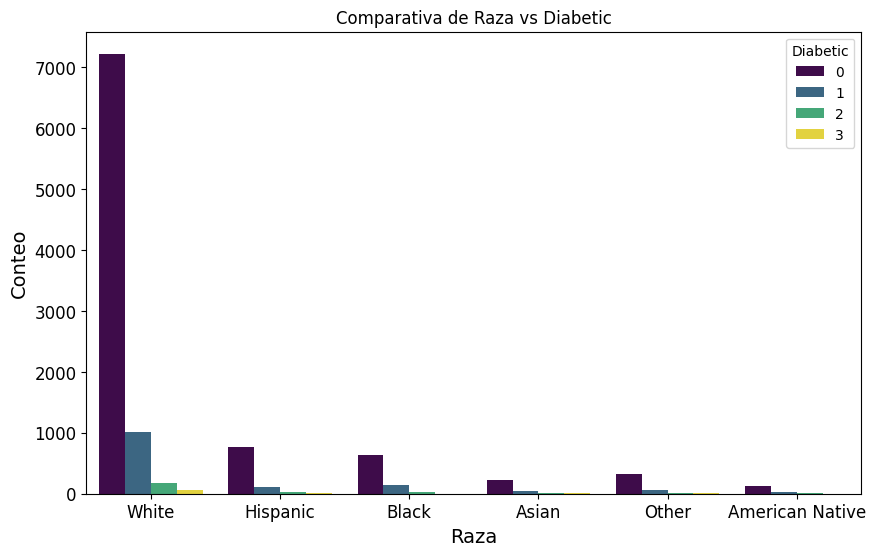

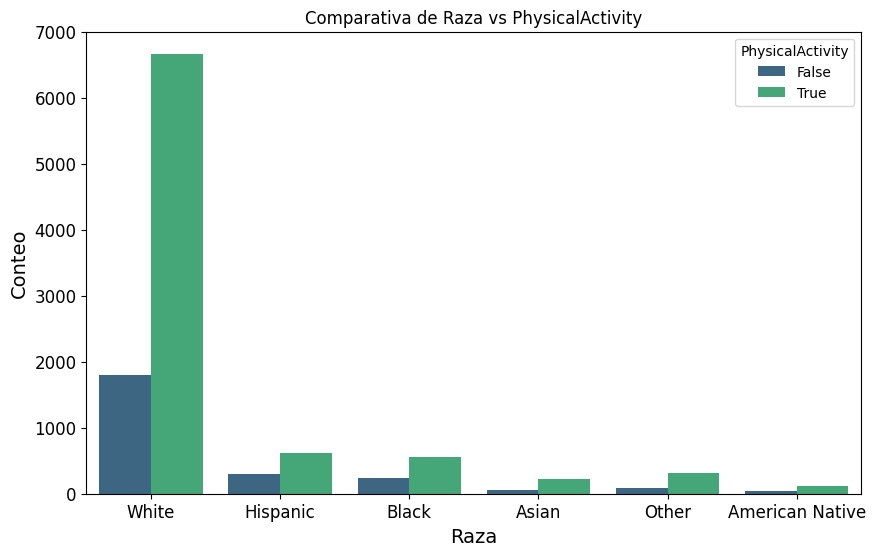

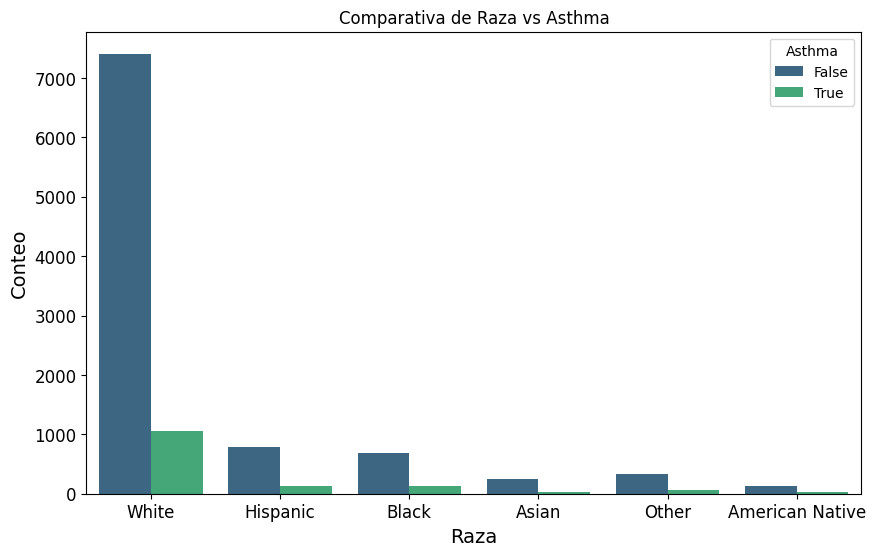

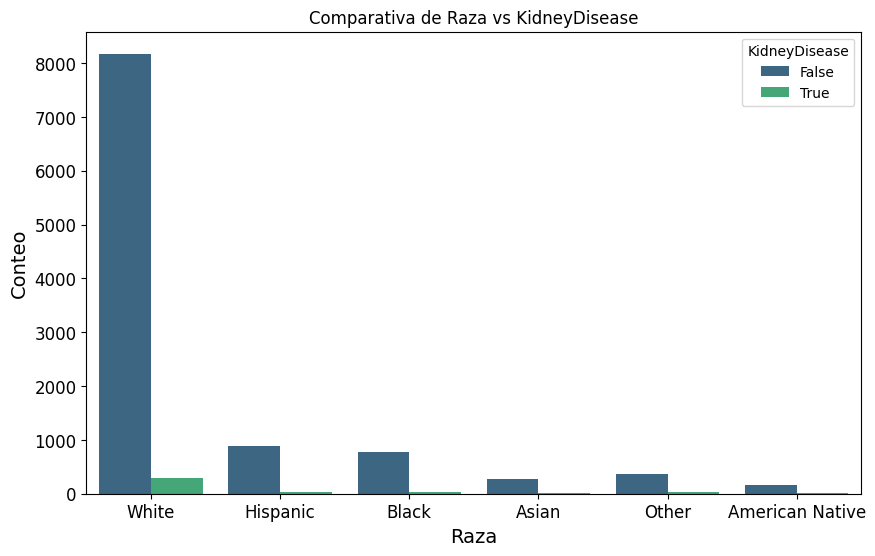

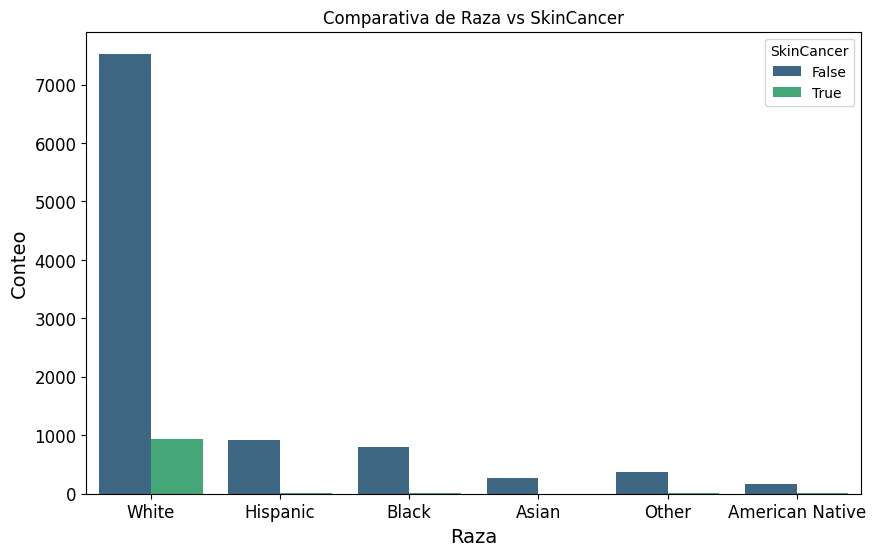

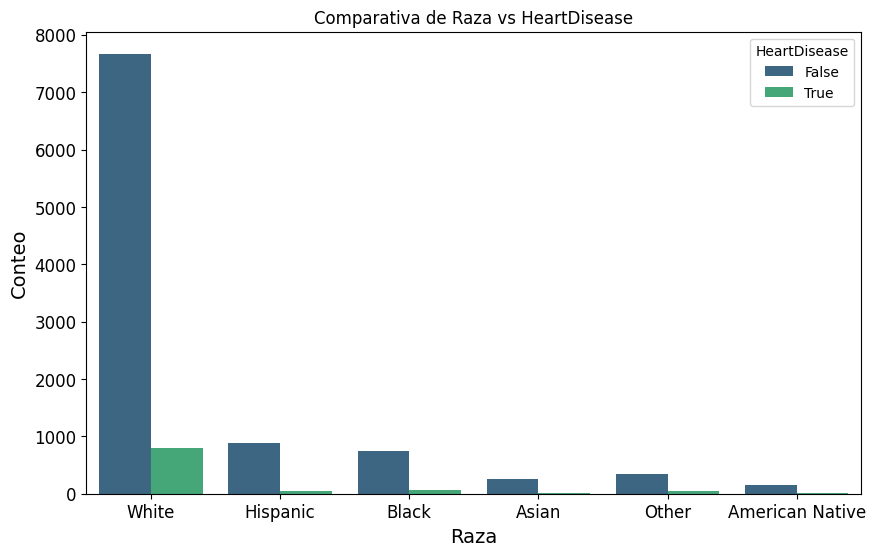

                       p-value
Smoking           7.698957e-26
AlcoholDrinking   4.089214e-03
Stroke            1.157059e-02
DiffWalking       3.272512e-08
Diabetic          3.113820e-11
PhysicalActivity  5.196904e-17
Asthma            2.442724e-03
KidneyDisease     9.843658e-02
SkinCancer        3.415243e-48
HeartDisease      6.249737e-06


In [28]:
# Crear una copia del dataset con las etiquetas de raza mapeadas
cardio_with_labels = cardio.copy()
cardio_with_labels['Race'] = cardio_with_labels['Race'].map(race_labels)



for col in boolean_columns:
    contingency_table = pd.crosstab(cardio['Race'], cardio[col])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[col] = p

    # Visualización usando el dataset con etiquetas de raza
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Race', hue=col, data=cardio_with_labels, palette='viridis')
    plt.title(f'Comparativa de Raza vs {col}')
    plt.xlabel('Raza')
    plt.ylabel('Conteo')
    plt.legend(title=col)
    plt.show()

# Mostrar los resultados de las pruebas de Chi-cuadrado
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p-value'])
print(chi2_results_df)


In [29]:
# Crear tablas de contingencia para 'Smoking' y 'SkinCancer'
contingency_smoking = pd.crosstab(cardio_with_labels['Race'], cardio_with_labels['Smoking'])
contingency_skincancer = pd.crosstab(cardio_with_labels['Race'], cardio_with_labels['SkinCancer'])

# Calcular porcentajes de cada categoría dentro de cada grupo racial
percentages_smoking = contingency_smoking.div(contingency_smoking.sum(axis=1), axis=0) * 100
percentages_skincancer = contingency_skincancer.div(contingency_skincancer.sum(axis=1), axis=0) * 100

# Mostrar tablas de contingencia y porcentajes
print("Tabla de Contingencia para Smoking:")
print(contingency_smoking)
print("\nPorcentajes para Smoking:")
print(percentages_smoking)

print("\nTabla de Contingencia para SkinCancer:")
print(contingency_skincancer)
print("\nPorcentajes para SkinCancer:")
print(percentages_skincancer)

# Realizar pruebas de Chi-cuadrado específicas y mostrar los resultados
chi2_smoking, p_smoking, dof_smoking, ex_smoking = chi2_contingency(contingency_smoking)
chi2_skincancer, p_skincancer, dof_skincancer, ex_skincancer = chi2_contingency(contingency_skincancer)

print(f"\nResultado de Chi-cuadrado para Smoking: p-value = {p_smoking}")
print(f"Resultado de Chi-cuadrado para SkinCancer: p-value = {p_skincancer}")

Tabla de Contingencia para Smoking:
Smoking          False  True 
Race                         
American Native     69     95
Asian              207     70
Black              529    276
Hispanic           647    277
Other              213    182
White             4821   3643

Porcentajes para Smoking:
Smoking              False      True 
Race                                 
American Native  42.073171  57.926829
Asian            74.729242  25.270758
Black            65.714286  34.285714
Hispanic         70.021645  29.978355
Other            53.924051  46.075949
White            56.958885  43.041115

Tabla de Contingencia para SkinCancer:
SkinCancer       False  True 
Race                         
American Native    158      6
Asian              277      0
Black              801      4
Hispanic           913     11
Other              379     16
White             7528    936

Porcentajes para SkinCancer:
SkinCancer            False      True 
Race                                  
Ameri

Conclusión

Dado que todos los p-values son extremadamente pequeños (mucho menores que 0.05), podemos concluir que hay una asociación significativa entre la raza y cada una de las variables booleanas listadas. Esto sugiere que la raza está asociada con diferencias en las tasas de tabaquismo, consumo de alcohol, incidencia de accidentes cerebrovasculares, dificultades para caminar, diabetes, actividad física, asma, enfermedad renal, cáncer de piel y enfermedades del corazón.

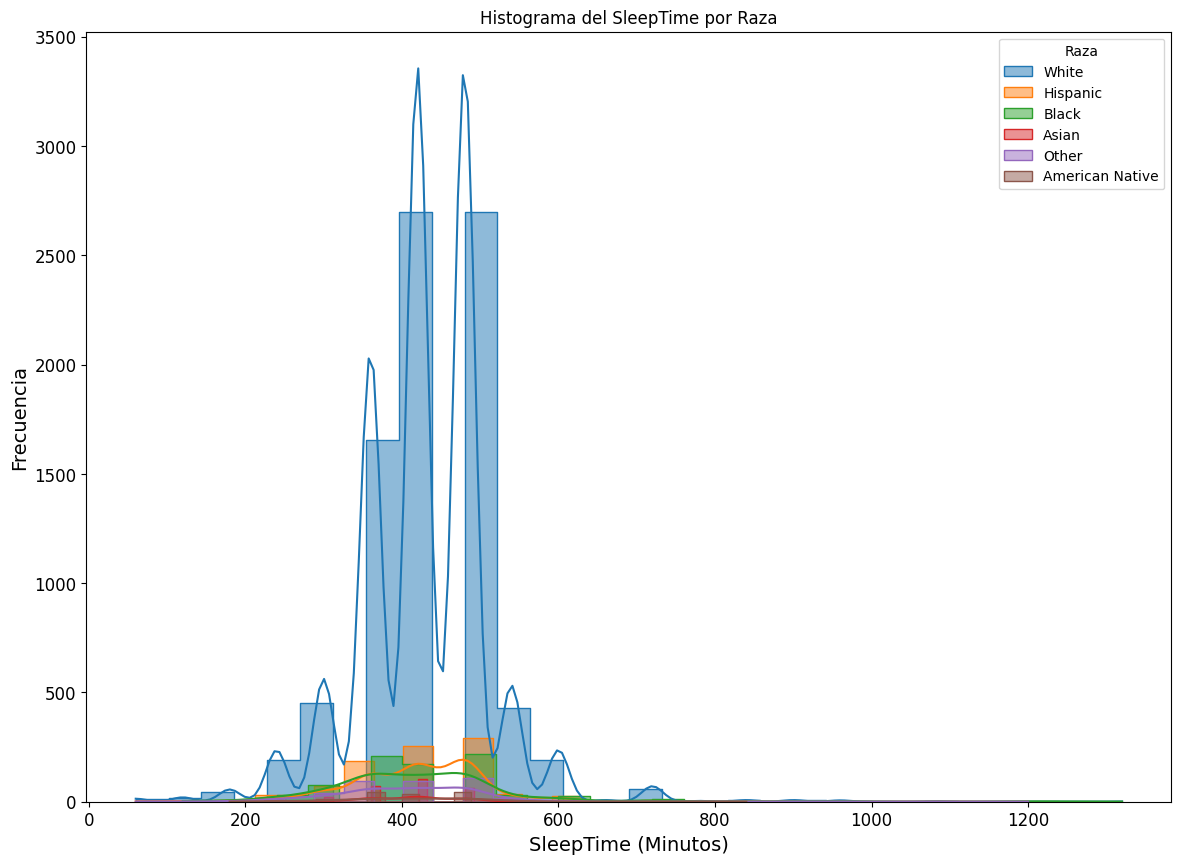

In [30]:
# Crear histogramas para la distribución del SleepTime por raza
plt.figure(figsize=(14, 10))
for race in cardio_with_labels['Race'].unique():
    sns.histplot(cardio_with_labels[cardio_with_labels['Race'] == race]['SleepTime'], kde=True, label=race, bins=30, element="step")

plt.title('Histograma del SleepTime por Raza')
plt.xlabel('SleepTime (Minutos)')
plt.ylabel('Frecuencia')
plt.legend(title='Raza')
plt.show()



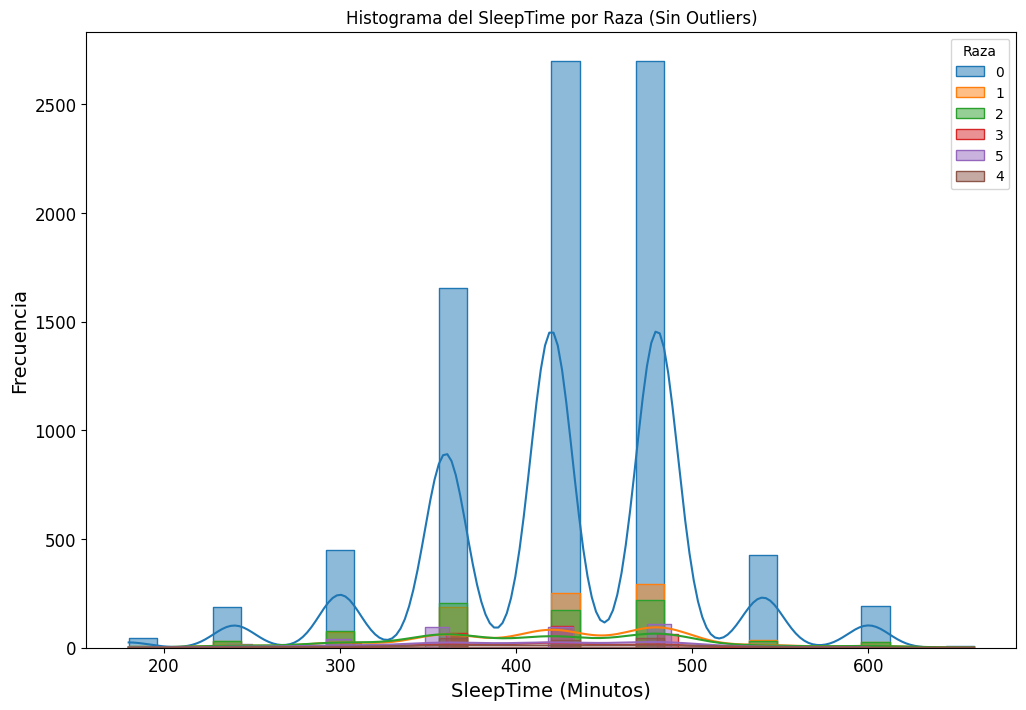

<ipython-input-31-038761ff0232>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Race', y='SleepTime', data=cardio_no_outliers, palette='viridis')


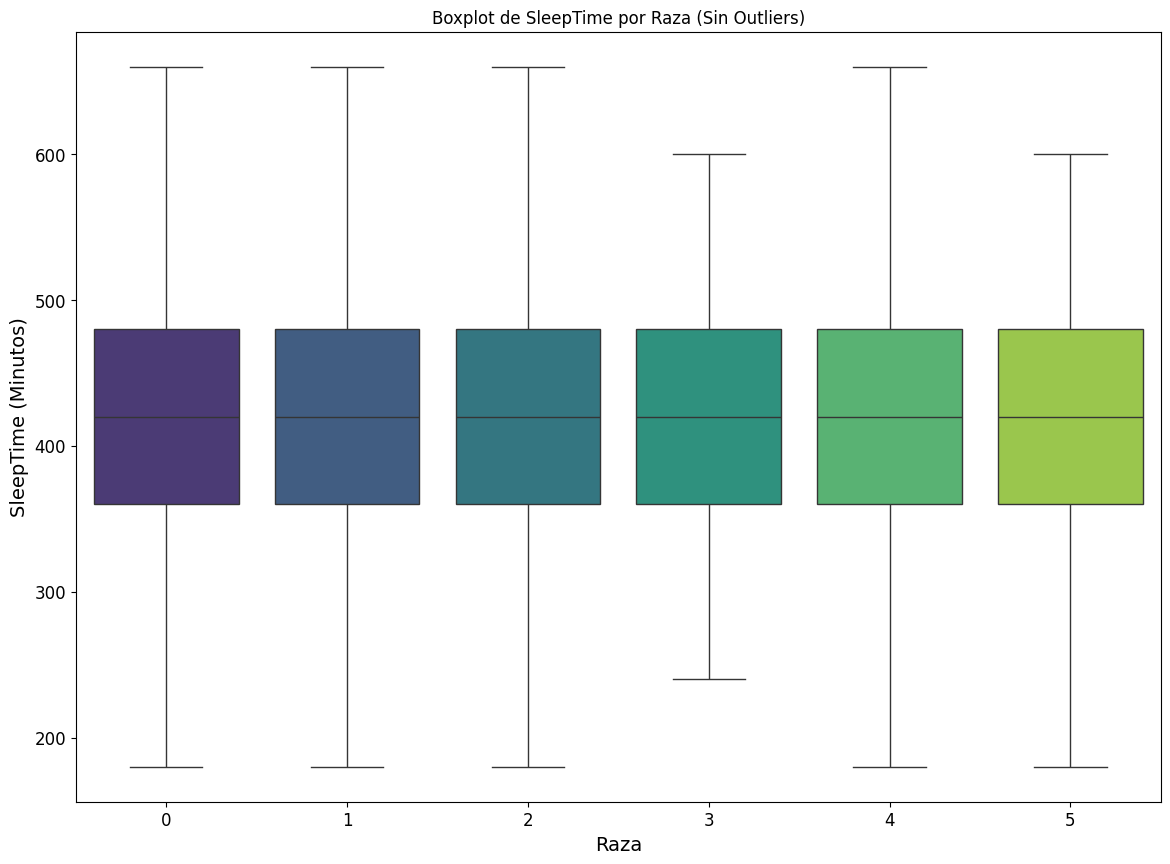

<ipython-input-31-038761ff0232>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Race', y='SleepTime', data=cardio_no_outliers, palette='viridis')


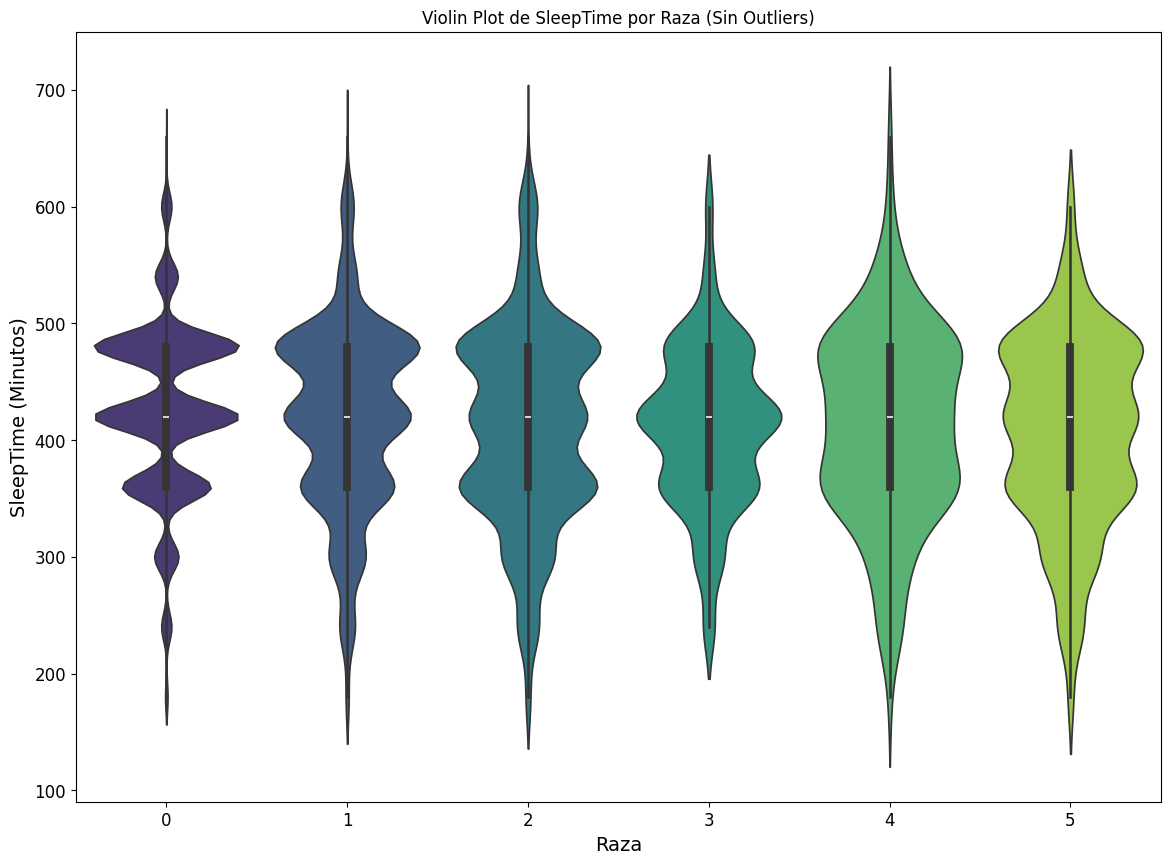

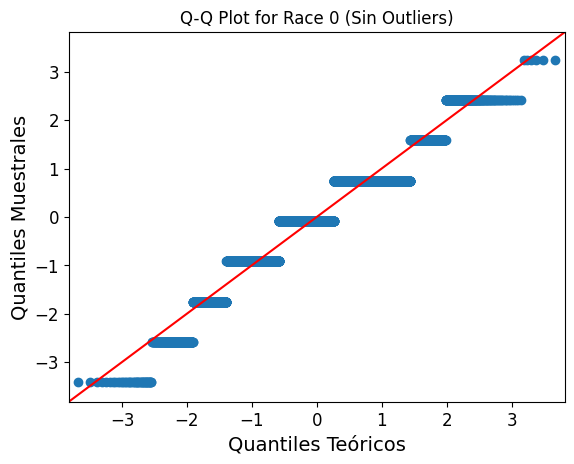

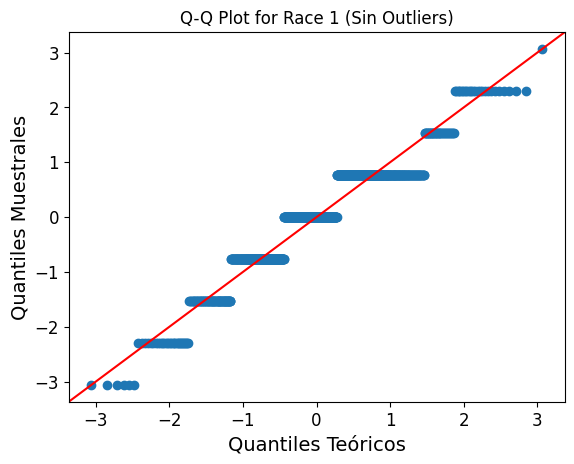

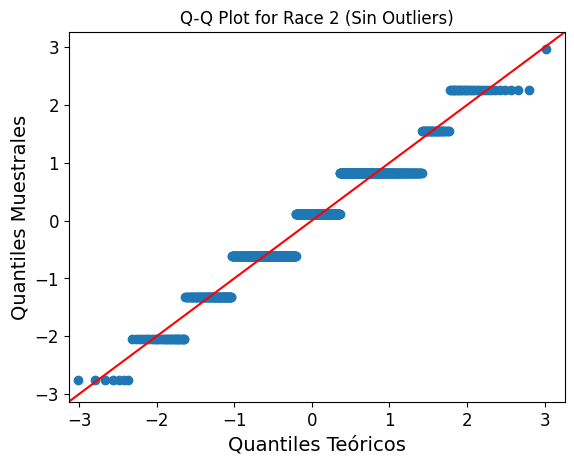

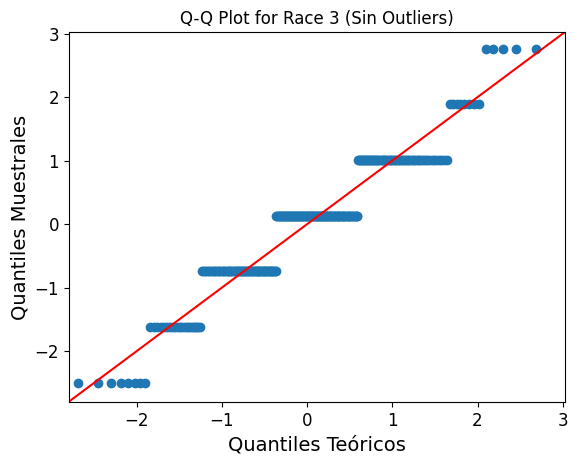

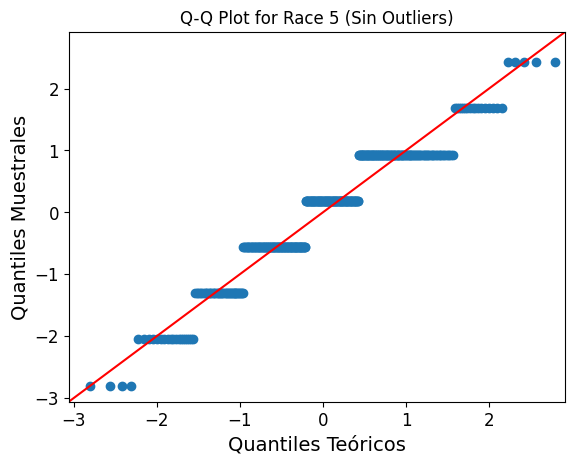

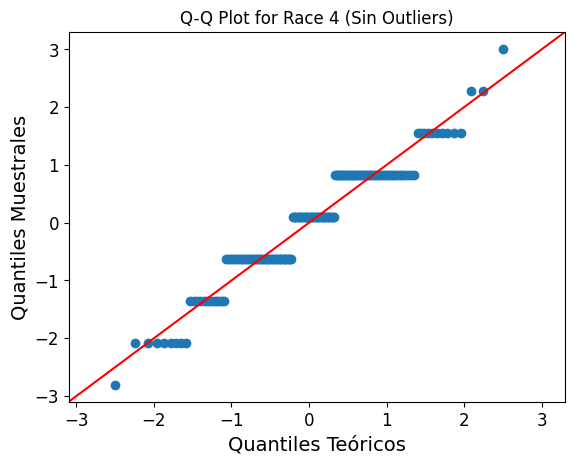

Resultado de la prueba de Kruskal-Wallis:
KruskalResult(statistic=67.96976899316184, pvalue=2.7093710970736586e-13)
              0         1             2         3        4         5
0  1.000000e+00  0.474523  8.921172e-07  0.001288  0.32754  0.000010
1  4.745225e-01  1.000000  1.305775e-01  0.246269  1.00000  0.038888
2  8.921172e-07  0.130578  1.000000e+00  1.000000  1.00000  1.000000
3  1.288295e-03  0.246269  1.000000e+00  1.000000  1.00000  1.000000
4  3.275398e-01  1.000000  1.000000e+00  1.000000  1.00000  1.000000
5  1.013287e-05  0.038888  1.000000e+00  1.000000  1.00000  1.000000


In [31]:
# Calcular el rango intercuartílico (IQR) para SleepTime
Q1 = cardio['SleepTime'].quantile(0.25)
Q3 = cardio['SleepTime'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
cardio_no_outliers = cardio[(cardio['SleepTime'] >= lower_bound) & (cardio['SleepTime'] <= upper_bound)]


# Crear histogramas para la distribución del SleepTime por raza sin outliers
plt.figure(figsize=(12, 8))
for race in cardio_no_outliers['Race'].unique():
    sns.histplot(cardio_no_outliers[cardio_no_outliers['Race'] == race]['SleepTime'], kde=True, label=race, bins=30, element="step")

plt.title('Histograma del SleepTime por Raza (Sin Outliers)')
plt.xlabel('SleepTime (Minutos)')
plt.ylabel('Frecuencia')
plt.legend(title='Raza')
plt.show()

plt.figure(figsize=(14, 10))
sns.boxplot(x='Race', y='SleepTime', data=cardio_no_outliers, palette='viridis')
plt.title('Boxplot de SleepTime por Raza (Sin Outliers)')
plt.xlabel('Raza')
plt.ylabel('SleepTime (Minutos)')
plt.show()

plt.figure(figsize=(14, 10))
sns.violinplot(x='Race', y='SleepTime', data=cardio_no_outliers, palette='viridis')
plt.title('Violin Plot de SleepTime por Raza (Sin Outliers)')
plt.xlabel('Raza')
plt.ylabel('SleepTime (Minutos)')
plt.show()

# Crear Q-Q Plots para visualizar la normalidad de los datos de SleepTime por raza sin outliers
for race in cardio_no_outliers['Race'].unique():
    race_data = cardio_no_outliers[cardio_no_outliers['Race'] == race]['SleepTime']
    sm.qqplot((race_data - race_data.mean()) / race_data.std(), line='45')
    plt.title(f'Q-Q Plot for Race {race} (Sin Outliers)')
    plt.xlabel('Quantiles Teóricos')
    plt.ylabel('Quantiles Muestrales')
    plt.show()

# Realizar la prueba de Kruskal-Wallis para SleepTime por raza
grouped_data = [cardio_no_outliers[cardio_no_outliers['Race'] == race]['SleepTime'] for race in cardio_no_outliers['Race'].unique()]
kruskal_result = kruskal(*grouped_data)

# Mostrar el resultado de la prueba
print("Resultado de la prueba de Kruskal-Wallis:")
print(kruskal_result)

# Realizar la prueba de Dunn para SleepTime por raza
dunn_result = sp.posthoc_dunn(cardio_no_outliers, val_col='SleepTime', group_col='Race', p_adjust='bonferroni')

# Mostrar los resultados de la prueba de Dunn
print(dunn_result)

In [32]:
# List of numerical columns to check
#numerical_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# Plot histograms and Q-Q plots for each variable by Race
#for column in numerical_columns:
 #   plt.figure(figsize=(15, 6))
  #  for race in cardio['Race'].unique():
   #     plt.subplot(1, 2, 1)
    #    sns.histplot(cardio[cardio['Race'] == race][column], kde=True, label=f'Race {race}', alpha=0.6)
     #   plt.title(f'Histograma de {column} por Raza')
      #  plt.xlabel(column)
       # plt.legend()
#
 #       plt.subplot(1, 2, 2)
  #      stats.probplot(cardio[cardio['Race'] == race][column], dist="norm", plot=plt)
   #     plt.title(f'Q-Q Plot de {column} para Raza {race}')
    #plt.tight_layout()
    #plt.show()

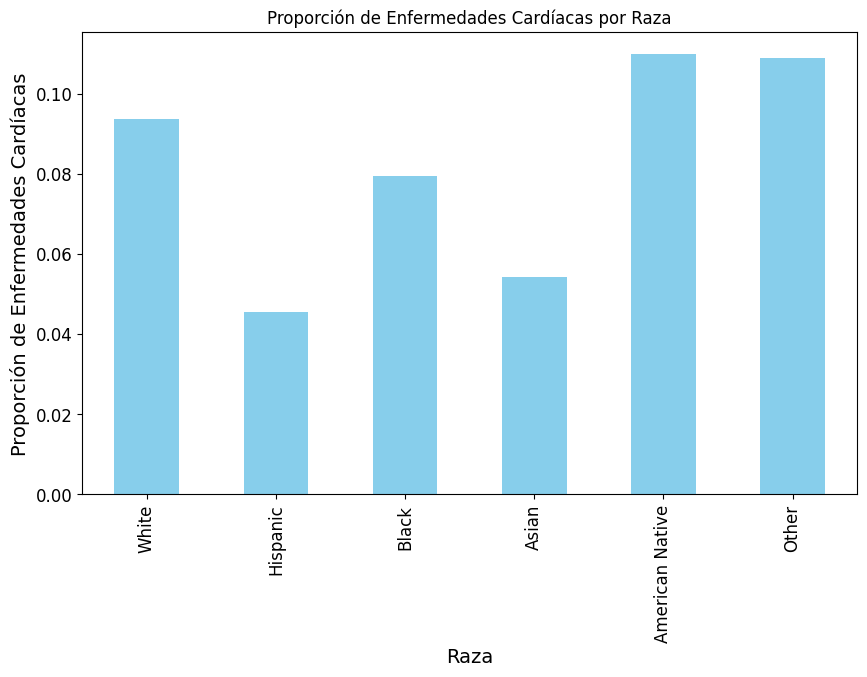

In [33]:
 #Calcular la proporción de enfermedades cardíacas por raza
heart_disease_by_race = cardio.groupby('Race')['HeartDisease'].mean()


plt.figure(figsize=(10, 6))
heart_disease_by_race.plot(kind='bar', color='skyblue')
plt.title('Proporción de Enfermedades Cardíacas por Raza')
plt.xlabel('Raza')
plt.ylabel('Proporción de Enfermedades Cardíacas')
plt.xticks(ticks=[0, 1, 2, 3, 4,5], labels=['White', 'Hispanic', 'Black', 'Asian','American Native' ,'Other'])
plt.show()

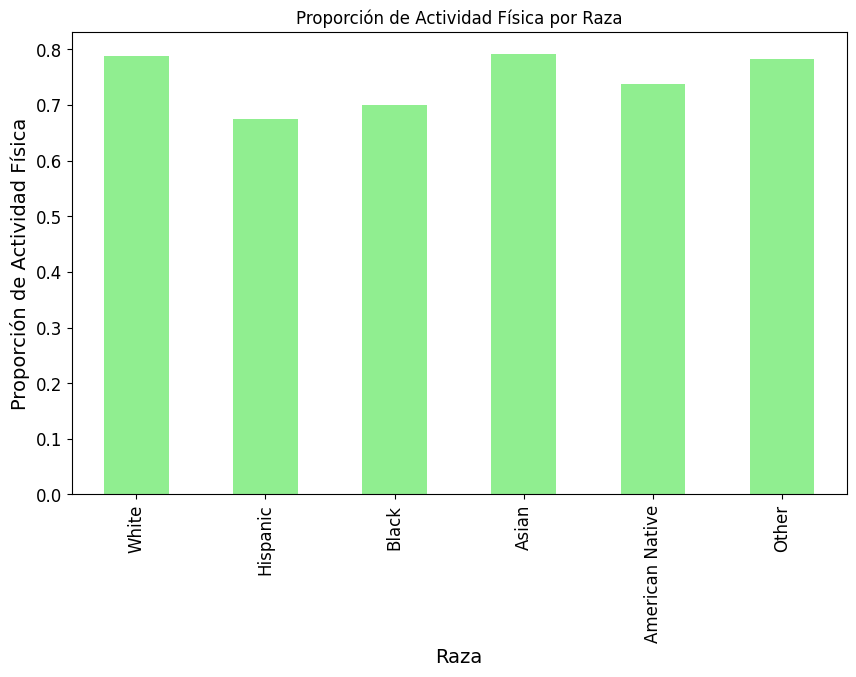

In [34]:
# Calcular la proporción de actividad física por raza
physical_activity_by_race = cardio.groupby('Race')['PhysicalActivity'].mean()

# Graficar los resultados
plt.figure(figsize=(10, 6))
physical_activity_by_race.plot(kind='bar', color='lightgreen')
plt.title('Proporción de Actividad Física por Raza')
plt.xlabel('Raza')
plt.ylabel('Proporción de Actividad Física')
plt.xticks(ticks=[0, 1, 2, 3, 4,5], labels=['White', 'Hispanic', 'Black', 'Asian','American Native' ,'Other'])
plt.show()

In [35]:
cardio_no_outliers.describe()

,Patient_ID,BMI,PhysicalHealth,MentalHealth,Sex,AgeCategory,Race,Diabetic,GenHealth,SleepTime
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000
mean,160118.191699,28.316069,3.179183,3.870882,0.527517,54.454721,0.540677,0.195196,3.610896,423.108780
std,92023.208489,6.388231,7.721189,7.931099,0.499265,18.324850,1.198731,0.501538,1.027593,73.993187
min,17.000000,13.390000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,1.000000,180.000000
25%,82004.500000,24.020000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,3.000000,360.000000
50%,159915.500000,27.280000,0.000000,0.000000,1.000000,57.000000,0.000000,0.000000,4.000000,420.000000
75%,240691.000000,31.380000,1.000000,3.000000,1.000000,67.000000,0.000000,0.000000,4.000000,480.000000
max,319777.000000,82.390000,30.000000,30.000000,1.000000,85.000000,5.000000,3.000000,5.000000,660.000000


In [36]:
cardio_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10866 entries, 0 to 11028
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        10866 non-null  int64  
 1   BMI               10866 non-null  float64
 2   Smoking           10866 non-null  bool   
 3   AlcoholDrinking   10866 non-null  bool   
 4   Stroke            10866 non-null  bool   
 5   PhysicalHealth    10866 non-null  float64
 6   MentalHealth      10866 non-null  float64
 7   DiffWalking       10866 non-null  bool   
 8   Sex               10866 non-null  int64  
 9   AgeCategory       10866 non-null  int64  
 10  Race              10866 non-null  int64  
 11  Diabetic          10866 non-null  int64  
 12  PhysicalActivity  10866 non-null  bool   
 13  GenHealth         10866 non-null  int64  
 14  SleepTime         10866 non-null  int64  
 15  Asthma            10866 non-null  bool   
 16  KidneyDisease     10866 non-null  bool   
 17

In [37]:
#Escalado de variables
#scaler = StandardScaler()
#cardio_no_outliers[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']] = scaler.fit_transform(cardio_no_outliers[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']])

In [38]:
corr_matrix_no_outliers = cardio_no_outliers.corr()


corr_matrix_no_outliers["Race"].sort_values(ascending=False)

Race                1.000000
Diabetic            0.054840
MentalHealth        0.047626
Asthma              0.027945
BMI                 0.027102
KidneyDisease       0.020467
PhysicalHealth      0.017166
DiffWalking         0.016655
Stroke             -0.002664
Sex                -0.006484
HeartDisease       -0.008358
Smoking            -0.020562
Patient_ID         -0.025237
AlcoholDrinking    -0.028931
PhysicalActivity   -0.033733
GenHealth          -0.059701
SleepTime          -0.077289
SkinCancer         -0.108034
AgeCategory        -0.146516
Name: Race, dtype: float64

In [39]:
cardio_no_outliers.describe()

,Patient_ID,BMI,PhysicalHealth,MentalHealth,Sex,AgeCategory,Race,Diabetic,GenHealth,SleepTime
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000
mean,160118.191699,28.316069,3.179183,3.870882,0.527517,54.454721,0.540677,0.195196,3.610896,423.108780
std,92023.208489,6.388231,7.721189,7.931099,0.499265,18.324850,1.198731,0.501538,1.027593,73.993187
min,17.000000,13.390000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,1.000000,180.000000
25%,82004.500000,24.020000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,3.000000,360.000000
50%,159915.500000,27.280000,0.000000,0.000000,1.000000,57.000000,0.000000,0.000000,4.000000,420.000000
75%,240691.000000,31.380000,1.000000,3.000000,1.000000,67.000000,0.000000,0.000000,4.000000,480.000000
max,319777.000000,82.390000,30.000000,30.000000,1.000000,85.000000,5.000000,3.000000,5.000000,660.000000


In [40]:
print(cardio_no_outliers.dtypes)

Patient_ID            int64
BMI                 float64
Smoking                bool
AlcoholDrinking        bool
Stroke                 bool
PhysicalHealth      float64
MentalHealth        float64
DiffWalking            bool
Sex                   int64
AgeCategory           int64
Race                  int64
Diabetic              int64
PhysicalActivity       bool
GenHealth             int64
SleepTime             int64
Asthma                 bool
KidneyDisease          bool
SkinCancer             bool
HeartDisease           bool
dtype: object


In [41]:
# Eliminar la columna 'HeartDisease' del DataFrame original para las características
cardio_features = cardio_no_outliers.drop("HeartDisease", axis=1)

# Copiar la columna 'HeartDisease' en una nueva variable para las etiquetas
cardio_labels = cardio_no_outliers["HeartDisease"].copy()

In [42]:
print(cardio_labels.value_counts(normalize=True))

HeartDisease
False    0.912203
True     0.087797
Name: proportion, dtype: float64


In [43]:
print(cardio_features.dtypes)

Patient_ID            int64
BMI                 float64
Smoking                bool
AlcoholDrinking        bool
Stroke                 bool
PhysicalHealth      float64
MentalHealth        float64
DiffWalking            bool
Sex                   int64
AgeCategory           int64
Race                  int64
Diabetic              int64
PhysicalActivity       bool
GenHealth             int64
SleepTime             int64
Asthma                 bool
KidneyDisease          bool
SkinCancer             bool
dtype: object


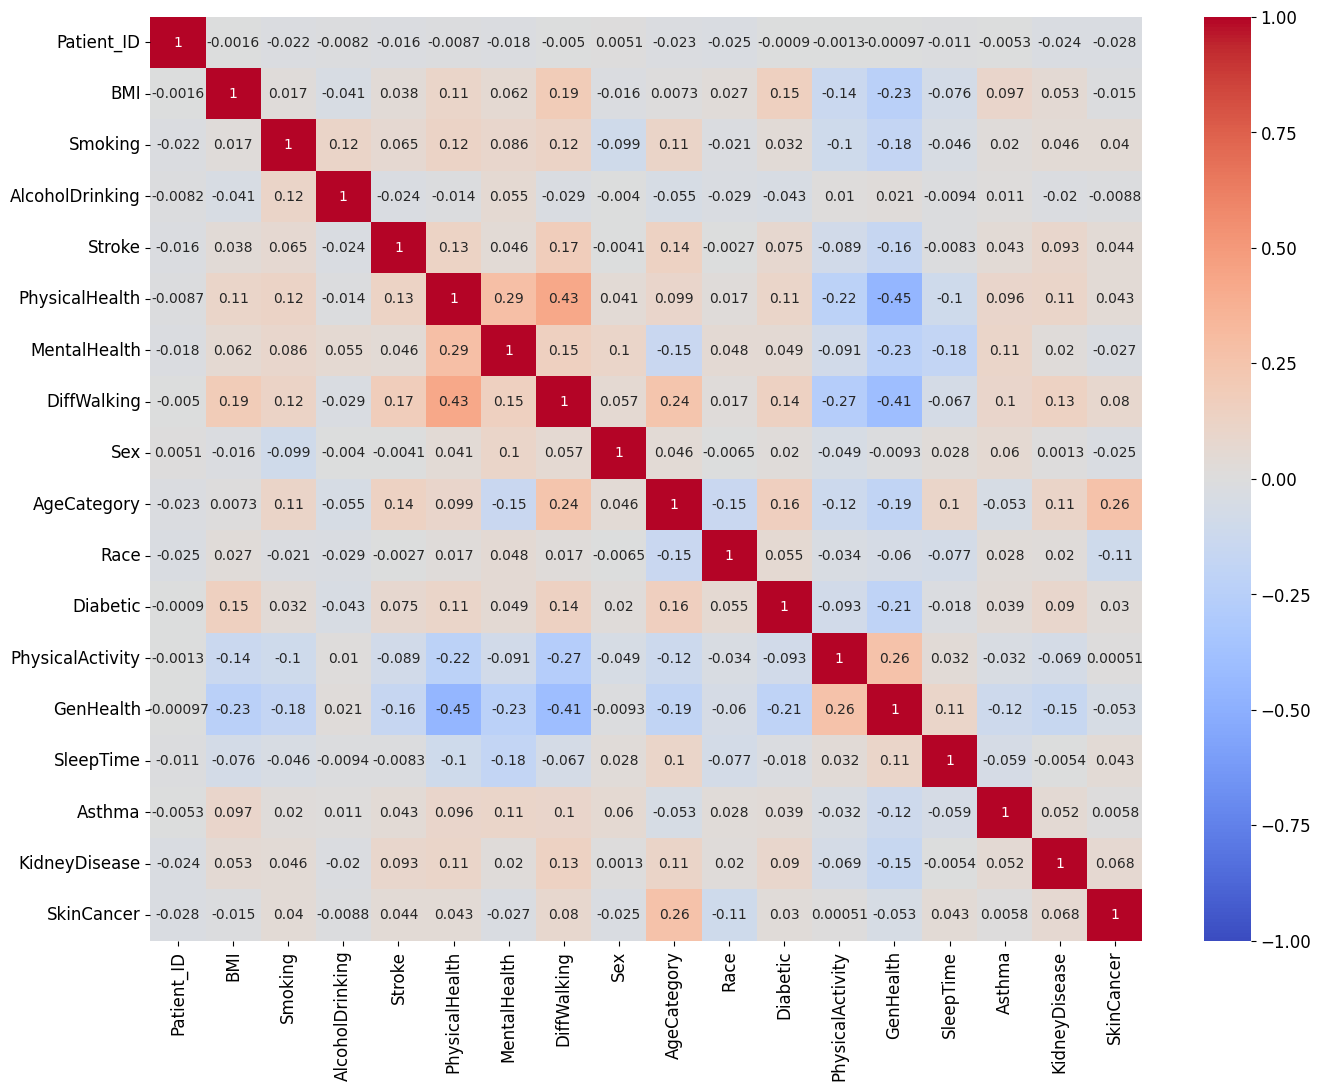

In [44]:
# Crear matriz de correlación
corr_matrix = cardio_features.corr()

# Mostrar el heatmap de la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [45]:
corr_matrix = cardio_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.75)]
print("Variables con alta correlación:", high_corr_features)

Variables con alta correlación: []


In [46]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(cardio_features, cardio_labels, test_size=0.2, random_state=42)

In [47]:
print(y_train)

5755     False
2491     False
403      False
10105    False
3078     False
         ...  
5806     False
5259     False
5458     False
876      False
7357      True
Name: HeartDisease, Length: 8692, dtype: bool


In [48]:
print(y_train.dtype)

bool


In [49]:
# Aplicar SMOTE + ENN en el conjunto de entrenamiento
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [50]:
# Escalar los datos
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [51]:
# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled_scaled, y_resampled)

RandomForestClassifier(random_state=42)

In [52]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8463661453541859
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.91      1979
        True       0.27      0.42      0.33       195

    accuracy                           0.85      2174
   macro avg       0.61      0.65      0.62      2174
weighted avg       0.88      0.85      0.86      2174

Confusion Matrix:
[[1758  221]
 [ 113   82]]


In [53]:
# Definir los parámetros a probar
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Ajustar el modelo
grid_search_rf.fit(X_resampled_scaled, y_resampled)

# Mostrar los mejores parámetros y el mejor score
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor score: {grid_search_rf.best_score_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejores parámetros: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mejor score: 0.9258578798674347
Accuracy: 0.8330266789328427
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.87      0.90      1979
        True       0.26      0.48      0.34       195

    accuracy                           0.83      2174
   macro avg       0.60      0.67      0.62      2174
weighted avg       0.88      0.83      0.85      2174

Confusion Matrix:
[[1718  261]
 [ 102   93]]


In [54]:
# Aplicar SMOTE solo en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [60]:
print(y_resampled.value_counts())

HeartDisease
False    7933
True     7933
Name: count, dtype: int64


In [55]:
# Escalar los datos
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [56]:
# Crear el modelo de XGBoost con manejo de desbalanceo
scale_pos_weight = 204695 / 19160  # Ratio entre clases negativas y positivas
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo
model.fit(X_resampled_scaled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8298068077276909
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.87      0.90      1979
        True       0.24      0.42      0.31       195

    accuracy                           0.83      2174
   macro avg       0.59      0.65      0.61      2174
weighted avg       0.88      0.83      0.85      2174

Confusion Matrix:
[[1722  257]
 [ 113   82]]


In [57]:
# Definir los parámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Crear el modelo de XGBoost con manejo de desbalanceo
scale_pos_weight = 204695 / 19160
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Ajustar el modelo
grid_search.fit(X_resampled_scaled, y_resampled)

# Mostrar los mejores parámetros y el mejor score
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score: {grid_search.best_score_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluar el modelo
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Mejor score: 0.9229851658639582
Accuracy: 0.8712051517939282
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      1979
        True       0.27      0.25      0.26       195

    accuracy                           0.87      2174
   macro avg       0.60      0.59      0.59      2174
weighted avg       0.87      0.87      0.87      2174

Confusion Matrix:
[[1845  134]
 [ 146   49]]
